# Analyse missing data to assess quality of (early) records

This notebook focuses on vanessa atalanta (migratory) and Inachis io (local). The output/figures of this notebook are stored in the _missing-data_ subdirectory.

In [27]:
# import libraries
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from IPython.display import display
import re
import seaborn as sns
sns.set_theme(
    style="darkgrid",
    color_codes=True,
    palette='Dark2',
)

# import (personal) functions & variables
from funcs import import_pickled_data, which_cols, number_of_day_to_date, highlight_years, first_last_day
from vals import sheets, yrs
species, species_long, species_summed = import_pickled_data()

### How many nan-values does the Kaliningrad dataset contain (especially in the early years)?

Here, we want to focus on the temperature as well as insect count.

In [28]:
# import data
va = species['Vanessa atalanta'].reset_index()
va.name = 'Vanessa atalanta'
io = species['Inachis io'].reset_index()
io.name = 'Inachis io'

In [29]:
# create new pandas dataframe to hold count of nan's
nans = pd.DataFrame(columns=['year', 'species', 'var', 'nans_tot', 'nans_apr'])

# loop over species data frames
for s in [va, io]:
    # loop over years
    for y in yrs:
        # number of nan's in temperature
        tmp_nans = s['Temp'][s.Year == y].isnull().sum()
        tmp_nans_apr = s['Temp'][s.Year == y][:31].isnull().sum()
        # add to nan data frame
        nans = nans.append(
            pd.Series([y, s.name, 'tmp', tmp_nans, tmp_nans_apr], 
                      index=nans.columns),
            ignore_index=True
        )
        # number of nan's in (insect) count
        cnt_nans = s['count'][s.Year == y].isnull().sum()
        cnt_nans_apr = s['count'][s.Year == y][:31].isnull().sum()
        # add to nan data frame
        nans = nans.append(
            pd.Series([y, s.name, 'cnt', cnt_nans, cnt_nans_apr], 
                      index=nans.columns),
            ignore_index=True
        )
nans

,year,species,var,nans_tot,nans_apr
0,1982,Vanessa atalanta,tmp,215,31
1,1982,Vanessa atalanta,cnt,177,31
2,1983,Vanessa atalanta,tmp,146,0
3,1983,Vanessa atalanta,cnt,89,7
4,1984,Vanessa atalanta,tmp,146,31
...,...,...,...,...,...
151,2018,Inachis io,cnt,9,2
152,2019,Inachis io,tmp,9,0
153,2019,Inachis io,cnt,7,0
154,2020,Inachis io,tmp,11,3


In [30]:
def plot_nans(species):
    fig, axs = plt.subplots(2, 1, figsize=(12,8))

    sns.barplot(data=nans[nans.species == species], x='year', y='nans_apr', hue='var', ax=axs[0])
    sns.barplot(data=nans[nans.species == species], x='year', y='nans_tot', hue='var', ax=axs[1])

    axs[0].set_xticklabels([str(year) for year in range(1982, 2021, 1)], rotation=90)
    axs[1].set_xticklabels([str(year) for year in range(1982, 2021, 1)], rotation=90)

    fig.suptitle(f'{species}: Number of missing values in April & entire year')
    fig.savefig(f'../figs/missing-data/{species}.pdf', bbox_inches='tight')

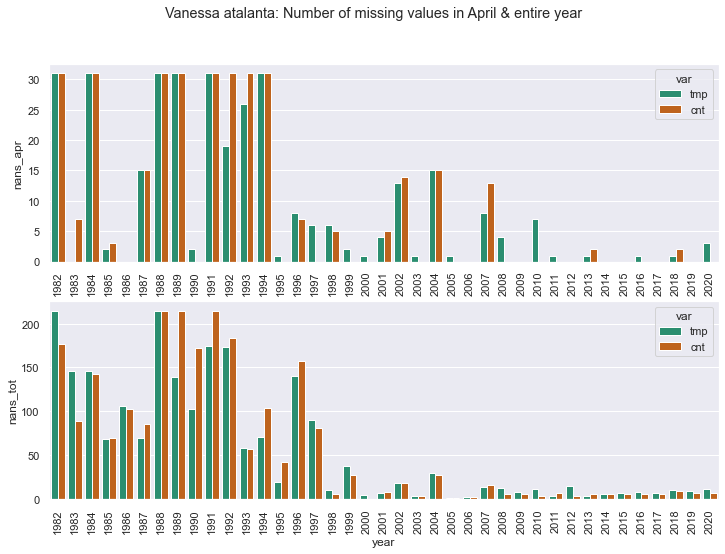

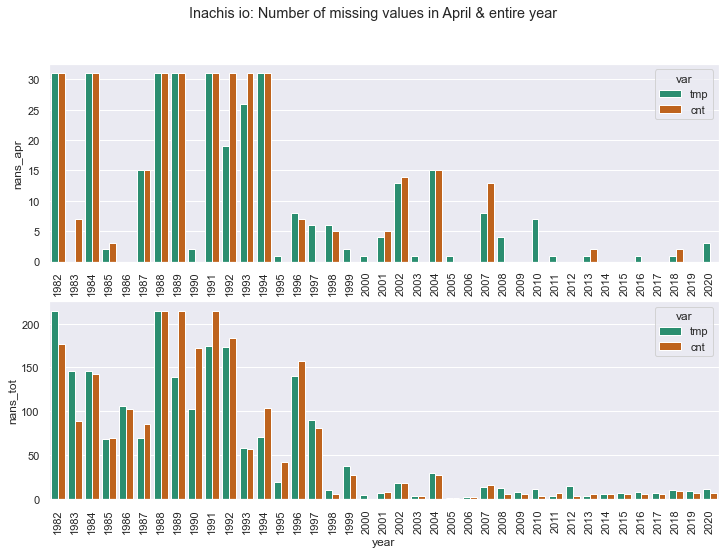

In [31]:
# plotting
plot_nans('Vanessa atalanta')
plot_nans('Inachis io')

# and save data
nans.to_csv('../number-of-nans_first-df.csv', index=False)

The two figures are the same, consequently, the Kaliningrad researchers weren't doing any partial insect recording. If there's missing data for a single species, no other insects were recorded at that day (obviously, the same reasoning holds for temperature).

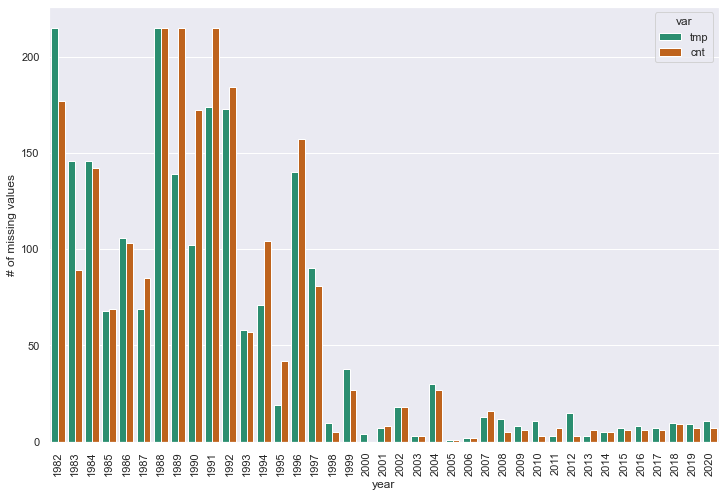

In [32]:
# let's do some more plotting to create an easier-to-understand version of the missing values plot

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=nans[nans.species == "Inachis io"], x='year', y='nans_tot', hue='var', ax=ax)
ax.set_xticklabels([str(year) for year in range(1982, 2021, 1)], rotation=90)
ax.set_ylabel("# of missing values")
fig.savefig(f'../figs/missing-data/nans_per-year.pdf', bbox_inches='tight')

## Update 21/05/22

Let's try are more rigorous approach for finding potential differences in number of missing values between species.

In [33]:
# get data into tidy form!
# i.e., single dataframe with variables as columns and single observations as rows

sheets = ['Vanessa atalanta', 'Vanessa cardui', 'Inachis io', 'Issoria lathonia', 'Aglais urticae',
          'Aporia crataegi', 'Apatura ilia', 'Aphantopus hyperanthus', 'Araschnia levana', 'Nymphalis antiopa',
          'Nymphalis polychloros', 'Nymphalis xanthomelas', 'Papilio machaon', 'Polygonia c-album', 'Pararge aegeria']

all_species = pd.DataFrame()
for s in sheets:
    df = species_summed[s]
    df['species'] = s # add species column
    df = df[['species', 'datetime', 'count', 'Temp', 'Wind', 'Cloud']] # select columns
    all_species = pd.concat([all_species, df]) # put final df together

# rename columns
all_species.rename(
    columns={'Temp': 'tmp', 'Wind': 'wind', 'Cloud':'cloud'}, 
    inplace=True
)

# NOTE: remove high tmp values!
all_species['tmp'].values[all_species['tmp'] > 50] = np.nan

# add year, month, day column
all_species['year'] = all_species['datetime'].dt.year
all_species['month'] = all_species['datetime'].dt.month
all_species['day'] = all_species['datetime'].dt.day

display(all_species)

,species,datetime,count,tmp,wind,cloud,year,month,day
0,Vanessa atalanta,1982-04-01,NaN,NaN,W,0,1982,4,1
1,Vanessa atalanta,1982-04-02,NaN,NaN,W,0,1982,4,2
2,Vanessa atalanta,1982-04-03,NaN,NaN,NE-E,1/2,1982,4,3
3,Vanessa atalanta,1982-04-04,NaN,NaN,W-NW,1/2,1982,4,4
4,Vanessa atalanta,1982-04-05,NaN,NaN,NW-W,0,1982,4,5
...,...,...,...,...,...,...,...,...,...
8380,Pararge aegeria,2020-10-28,NaN,NaN,NaN,NaN,2020,10,28
8381,Pararge aegeria,2020-10-29,NaN,NaN,NaN,NaN,2020,10,29
8382,Pararge aegeria,2020-10-30,NaN,NaN,NaN,NaN,2020,10,30
8383,Pararge aegeria,2020-10-31,NaN,NaN,NaN,NaN,2020,10,31


In [34]:
# compute annual number of missing values per species
nans_species_year = (all_species['count'].isna()
                                         .groupby([all_species.species, all_species.year])
                                         .sum()
                                         .reset_index())

# and find out whether there's always the same number of missing values per year 
nans_diff = (nans_species_year.groupby('year')['count']
                              .nunique()
                              .eq(1)
                              .reset_index()
                              .rename(columns = {'count': 'is_equal'}))

# print years with distinct values
display(nans_diff[~nans_diff.is_equal])

,year,is_equal
14,1996,False
15,1997,False
25,2007,False


In [35]:
# What happened in those years?
for yr in [1996, 1997, 2007]:
    display(nans_species_year[nans_species_year.year == yr])

# TODO: We might be able to replace missing values with zeros?

,species,year,count
14,Aglais urticae,1996,1
53,Apatura ilia,1996,1
92,Aphantopus hyperanthus,1996,1
131,Aporia crataegi,1996,1
170,Araschnia levana,1996,1
209,Inachis io,1996,157
248,Issoria lathonia,1996,1
287,Nymphalis antiopa,1996,1
326,Nymphalis polychloros,1996,1
365,Nymphalis xanthomelas,1996,1


,species,year,count
15,Aglais urticae,1997,2
54,Apatura ilia,1997,2
93,Aphantopus hyperanthus,1997,2
132,Aporia crataegi,1997,2
171,Araschnia levana,1997,2
210,Inachis io,1997,81
249,Issoria lathonia,1997,2
288,Nymphalis antiopa,1997,2
327,Nymphalis polychloros,1997,2
366,Nymphalis xanthomelas,1997,2


,species,year,count
25,Aglais urticae,2007,14
64,Apatura ilia,2007,14
103,Aphantopus hyperanthus,2007,14
142,Aporia crataegi,2007,14
181,Araschnia levana,2007,14
220,Inachis io,2007,16
259,Issoria lathonia,2007,16
298,Nymphalis antiopa,2007,14
337,Nymphalis polychloros,2007,14
376,Nymphalis xanthomelas,2007,14


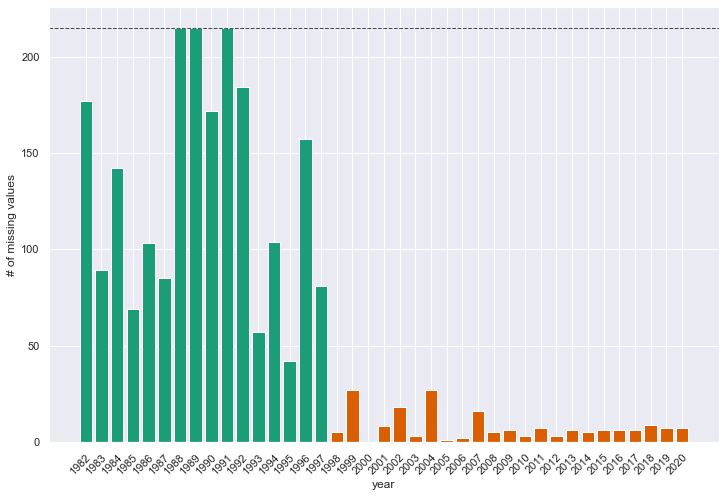

In [36]:
fig, ax = plt.subplots(figsize=(12,8))

ax.bar(data=nans_species_year[(nans_species_year.species == 'Inachis io')
                               & (nans_species_year.year < 1998)],
       x='year', height='count', color=cm.Dark2(0))
ax.bar(data=nans_species_year[(nans_species_year.species == 'Inachis io')
                               & (nans_species_year.year >= 1998)],
       x='year', height='count', color=cm.Dark2(1))

# xticks and xlabels magic:
yrs = [year for year in range(1982, 2021, 1)]
ax.set_xticks(yrs)
ax.set_xticklabels(yrs, rotation=45, ha='right', rotation_mode='anchor')

ax.axhline(215, color='k', alpha=0.7, lw=1, ls='--')
ax.set_ylabel("# of missing values")
ax.set_xlabel("year")
fig.savefig(f'../figs/missing-data/nans_per-year_updated.png', bbox_inches='tight', dpi=600)

## Update 08/06/22

Same analysis, but with updated data. Therefore, let's import the data from raw excel file.

In [37]:
# data import from updated raw excel file
def store_as_dict(filepath, species):
    # IMPORT ALL SHEETS
    df = pd.read_excel(
        io=filepath,
        sheet_name=species,
        header=[0,1],                   # row to use for column labels
        skipfooter=2,
        dtype={('Year', 'Date'): str}   # save date as string, otherwise float abbreviation (01.10 -> 1.1)  
    )
    # DATA PREPARATION
    df_upd = (
        df
        .set_index(('Year', 'Date'))
        .drop(labels='Total', axis=1)
        .stack(level=0, dropna=False)
    )
    # labelling index columns and convert index to column
    df_upd.index.set_names('Day', level=0, inplace=True)
    df_upd.index.set_names('Year', level=1, inplace=True)
    df_upd = df_upd.reset_index()
    # convert date & year to datetime object
    df_upd['datetime'] = pd.to_datetime(
        arg = df_upd[['Year', 'Day']].astype(str).apply(' '.join, axis=1),
        format = '%Y %d.%m'
    )
    # and set datetime as index, then sort
    #df_upd = df_upd.set_index(keys='datetime').sort_index(axis=0)
    return df_upd

In [38]:
# trap openings are facing either north- or south-wards
def get_trap_direction(trap):
    if re.fullmatch('L-(2|3|5|8)', trap):
        return 'north'
    elif re.fullmatch('L-(1|4|7)', trap):
        return 'south'
    else:
        return np.nan

In [39]:
# convert dict to single dataframe in tidy format
def convert_to_single_df(species_dict):
    all_species = pd.DataFrame()
    for s in sheets:
        df = (
            species_dict[s]
            .reset_index()
            # convert data from wide to long format
            .melt(id_vars=['datetime', 'Cloud', 'Temp', 'Wind'],
                  value_vars=[f'L-{i}' for i in range(1, 6)] + ['L-7', 'L-8'],
                  var_name='trap',
                  value_name='temp_count')
            .rename(columns={'datetime': 'date', 
                             'Cloud': 'cloud',
                             'Temp': 'tmp',
                             'Wind': 'wind_dir',
                             'temp_count': 'count'})
            .sort_values(by=['date', 'trap'])
            .reset_index(drop=True)
        )
        # add year, month & day columns for easier grouping
        df['day'] = df['date'].dt.day
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
        # add trap direction and actual name of species
        df['trap_dir'] = df['trap'].apply(get_trap_direction)
        df['species'] = s
        # re-order columns in intuitive way
        column_order = [10, 0, 6, 7, 8, 4, 9, 5, 2, 1, 3]
        df = df[df.columns[column_order]]
        # merge all species into single dataframe
        all_species = pd.concat([all_species, df])

    all_species = all_species.reset_index(drop=True)
    return all_species

In [40]:
sheets = [
    'Vanessa atalanta', 'Vanessa cardui', 'Inachis io', 'Issoria lathonia', 'Aglais urticae',
    'Aporia crataegi', 'Apatura ilia', 'Aphantopus hyperanthus', 'Araschnia levana', 'Nymphalis antiopa',
    'Nymphalis polychloros', 'Nymphalis xanthomelas', 'Papilio machaon', 'Polygonia c-album', 'Pararge aegeria'
]

species = dict()
for s in sheets:
    species[f'{s}'] = store_as_dict(
        filepath='../../data/Lepidoptera_records_Courish_Spit_2020.xls', # updated data
        species=s
    )

count_by_trap_updated = convert_to_single_df(species)
count_by_trap_updated

,species,date,day,month,year,trap,trap_dir,count,tmp,cloud,wind_dir
0,Vanessa atalanta,1982-04-01,1,4,1982,L-1,south,NaN,NaN,0,W
1,Vanessa atalanta,1982-04-01,1,4,1982,L-2,north,NaN,NaN,0,W
2,Vanessa atalanta,1982-04-01,1,4,1982,L-3,north,NaN,NaN,0,W
3,Vanessa atalanta,1982-04-01,1,4,1982,L-4,south,NaN,NaN,0,W
4,Vanessa atalanta,1982-04-01,1,4,1982,L-5,north,NaN,NaN,0,W
...,...,...,...,...,...,...,...,...,...,...,...
902995,Pararge aegeria,2021-11-01,1,11,2021,L-3,north,NaN,NaN,NaN,NaN
902996,Pararge aegeria,2021-11-01,1,11,2021,L-4,south,NaN,NaN,NaN,NaN
902997,Pararge aegeria,2021-11-01,1,11,2021,L-5,north,NaN,NaN,NaN,NaN
902998,Pararge aegeria,2021-11-01,1,11,2021,L-7,south,NaN,NaN,NaN,NaN


In [41]:
# create another dataframe with daily total counts (all traps combined)
count_daily_updated = count_by_trap_updated.drop(columns = ['trap', 'trap_dir'])
count_daily_updated['count'] = count_daily_updated.groupby(['species', 'date'])['count'].transform('sum', min_count=1)
count_daily_updated = count_daily_updated.drop_duplicates().reset_index(drop=True)

count_daily_updated

,species,date,day,month,year,count,tmp,cloud,wind_dir
0,Vanessa atalanta,1982-04-01,1,4,1982,NaN,NaN,0,W
1,Vanessa atalanta,1982-04-02,2,4,1982,NaN,NaN,0,W
2,Vanessa atalanta,1982-04-03,3,4,1982,NaN,NaN,1/2,NE-E
3,Vanessa atalanta,1982-04-04,4,4,1982,NaN,NaN,1/2,W-NW
4,Vanessa atalanta,1982-04-05,5,4,1982,NaN,NaN,0,NW-W
...,...,...,...,...,...,...,...,...,...
128995,Pararge aegeria,2021-10-28,28,10,2021,NaN,NaN,NaN,NaN
128996,Pararge aegeria,2021-10-29,29,10,2021,NaN,NaN,NaN,NaN
128997,Pararge aegeria,2021-10-30,30,10,2021,NaN,NaN,NaN,NaN
128998,Pararge aegeria,2021-10-31,31,10,2021,NaN,NaN,NaN,NaN


In [42]:
# compute annual number of missing values per species
nans_species_year = (
    count_daily_updated['count']
    .isna()
    .groupby([count_daily_updated.species, count_daily_updated.year])
    .sum()
    .reset_index()
)
    
nans_species_year.sort_values(by='year', ignore_index=True, inplace=True)
nans_species_year.to_csv('../number-of-nans_updated.csv')

In [43]:
# and find out whether there's always the same number of missing values per year 
nans_diff = (nans_species_year.groupby('year')['count']
                              .nunique()
                              .eq(1)
                              .reset_index()
                              .rename(columns = {'count': 'is_equal'}))

# print years with distinct values
display(nans_diff[~nans_diff.is_equal])

,year,is_equal
14,1996,False
15,1997,False
25,2007,False


Let's save the updated data frames for further analysis, e.g., in the anomalies directory!

In [44]:
count_daily_updated.to_csv('../../data/all_species_count_daily_upd.csv', index=False)
count_by_trap_updated.to_csv('../../data/all_species_count_by_trap_upd.csv', index=False)